# Mileage Exercise

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, log_loss
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy.io import arff
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, PowerTransformer

### Read all data files

In [3]:
# read all kinds of files in path
def read_file_by_kind(path):
    file_kind = file.split('.')[-1]
    if file_kind in ('csv', 'txt'):
        df = pd.read_csv(path + file)
    elif file_kind == 'arff':
        df = pd.DataFrame(arff.loadarff(path+file)[0])
    elif file_kind in ('data', 'dat', 'trn'):
        df = pd.read_table(path+file, delimiter=' ')
    elif file_kind in ('xls', 'xlsx'):
        df = pd.read_excel(path_classification + file)
    else:
        df= pd.DataFrame()
    return df

In [4]:
# read all classification files
path_classification = 'datasets/classification/'
original_cls_df = []
for file in os.listdir(path_classification):
    original_cls_df.append((read_file_by_kind(path_classification), file))

In [5]:
print(len(original_cls_df))

21


In [6]:
# read all regression files
path_regression = './datasets/regression/'
original_reg_df = []
for directory in os.listdir(path_regression):
    path = path_regression + directory +'/'
    for file in os.listdir(path):
        original_reg_df.append((read_file_by_kind(path), file))

In [7]:
print(len(original_reg_df))

20


In [8]:
def my_categorize(df):
    # one hot (get_dummies) for categorical columns
    cols_to_convert= [col for col in df.columns[df.dtypes == object]]
    return pd.get_dummies(df, dummy_na=False ,columns= cols_to_convert)

## Preprocess

### Regression datasets

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, jaccard_score, recall_score, confusion_matrix, roc_auc_score
from sklearn import neighbors, svm, metrics
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.metrics import auc,accuracy_score, mean_squared_error as mse

def get_score_regression(X_train, X_test, y_train, y_test, max_estimator=150, max_depth=15):
    
    random_grid = {"n_estimators": np.linspace(10, max_estimator, 10, dtype=int),
                   "max_depth": np.linspace(2, max_depth, 10, dtype=int),
                   "learning_rate": np.logspace(-5, 0, 15),
                  }
    
    cat_cls = CatBoostRegressor()
    xgb_cls = XGBRegressor(use_label_encoder=False, random_state=32)
    lgbm_cls = LGBMRegressor()
#     models = [('cat', cat_cls), ('xgb', xgb_cls), ('lgbm', lgbm_cls)]
    models = [('lgbm', lgbm_cls)]
    
    for name, model in models:
        random_model = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                                          n_iter=3, verbose=1, random_state=32, n_jobs=-1,
                                          return_train_score=True, cv=3)

        random_model.fit(X_train, y_train)
        y_pred = random_model.predict(X_test)
        y_pred_train = random_model.predict(X_train)
        
        results_dict = {
            'test mse': mse(y_pred, y_test),
            'train mse': mse(y_pred_train, y_train)
        }
        
        print('for model', name, "results are", results_dict)
    
#     tpot = TPOTRegressor(generations=5, population_size=5, verbosity=2, random_state=32, cv=5, n_jobs=-1, early_stop=50)
#     tpot.fit(X_train, y_train)
#     y_pred = tpot.predict(X_test)
#     y_pred_train = tpot.predict(X_train)

#     results_dict = {
#             'test mse': mse(y_pred, y_test),
#             'train mse': mse(y_pred_train, y_train)
#         }
        
#     print('for model TPOT', "results are", results_dict)

C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [10]:
labels = ['price', 'class']
for i, df_regression in enumerate(original_reg_df):
    df = df_regression[0]
#     df = df.dropna(subset=['price'])
    label_col = labels[i]
    data = df.drop(columns=['price'])
    for col in data.columns[data.dtypes == object]:
        data[col] = pd.factorize(data[col])[0]
    
    label = df['price']

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
    
    get_score_regression(X_train, X_test, y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [15]:
df = original_reg_df[0][0]

df = df.dropna(subset=['price'])
data = df.drop(columns=['price'])

for col in data.columns[data.dtypes == object]:
    data[col] = pd.factorize(data[col])[0]

label = df['price']

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

get_score_regression(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
for model lgbm results are {'test mse': 3092307.375096767, 'train mse': 644724.1559008129}


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.4s finished


## First regression dataset

In [11]:
df = original_reg_df[0][0]
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,highway-mpg,price,class
0,3.0,NaN,b'alfa-romero',b'gas',b'std',2.0,b'convertible',b'rwd',b'front',88.6,...,130.0,b'mpfi',3.47,2.68,9.0,5000.0,21.0,27.0,13495.0,111.0
1,3.0,NaN,b'alfa-romero',b'gas',b'std',2.0,b'convertible',b'rwd',b'front',88.6,...,130.0,b'mpfi',3.47,2.68,9.0,5000.0,21.0,27.0,16500.0,111.0
2,1.0,NaN,b'alfa-romero',b'gas',b'std',2.0,b'hatchback',b'rwd',b'front',94.5,...,152.0,b'mpfi',2.68,3.47,9.0,5000.0,19.0,26.0,16500.0,154.0
3,2.0,164.0,b'audi',b'gas',b'std',4.0,b'sedan',b'fwd',b'front',99.8,...,109.0,b'mpfi',3.19,3.40,10.0,5500.0,24.0,30.0,13950.0,102.0
4,2.0,164.0,b'audi',b'gas',b'std',4.0,b'sedan',b'4wd',b'front',99.4,...,136.0,b'mpfi',3.19,3.40,8.0,5500.0,18.0,22.0,17450.0,115.0


In [48]:
print(df.isnull().sum() / df.shape[0])
print(df.shape)

symboling            0.000000
normalized-losses    0.200000
make                 0.000000
fuel-type            0.000000
aspiration           0.000000
num-of-doors         0.009756
body-style           0.000000
drive-wheels         0.000000
engine-location      0.000000
wheel-base           0.000000
length               0.000000
width                0.000000
height               0.000000
curb-weight          0.000000
engine-type          0.000000
num-of-cylinders     0.000000
engine-size          0.000000
fuel-system          0.000000
bore                 0.019512
stroke               0.019512
compression-ratio    0.000000
peak-rpm             0.009756
city-mpg             0.000000
highway-mpg          0.000000
price                0.019512
class                0.009756
dtype: float64
(205, 26)


In [12]:
df = df.dropna(subset=['price'])
# df = df.dropna(axis=0)

data = df.drop(columns=['price'])
# data = my_categorize(data)

for col in data.columns[data.dtypes == object]:
    data[col] = pd.factorize(data[col])[0]

data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,highway-mpg,class
0,3.0,NaN,0,0,0,2.0,0,0,0,88.6,...,4.0,130.0,0,3.47,2.68,9.0,5000.0,21.0,27.0,111.0
1,3.0,NaN,0,0,0,2.0,0,0,0,88.6,...,4.0,130.0,0,3.47,2.68,9.0,5000.0,21.0,27.0,111.0
2,1.0,NaN,0,0,0,2.0,1,0,0,94.5,...,6.0,152.0,0,2.68,3.47,9.0,5000.0,19.0,26.0,154.0
3,2.0,164.0,1,0,0,4.0,2,1,0,99.8,...,4.0,109.0,0,3.19,3.40,10.0,5500.0,24.0,30.0,102.0
4,2.0,164.0,1,0,0,4.0,2,2,0,99.4,...,5.0,136.0,0,3.19,3.40,8.0,5500.0,18.0,22.0,115.0


In [13]:
label = df['price']

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

print(X_train.shape)

(160, 25)


In [14]:
get_score_regression(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
for model lgbm results are {'test mse': 2793122.898848329, 'train mse': 665768.1982179597}


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.7s finished


## Second regression dataset

In [93]:
df = original_reg_df[1][0]

df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,class
0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.4,10.0,102.0,5500.0,24.0,30.0,13950.0
1,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.4,8.0,115.0,5500.0,18.0,22.0,17450.0
2,1.0,158.0,105.8,192.7,71.4,55.7,2844.0,136.0,3.19,3.4,8.5,110.0,5500.0,19.0,25.0,17710.0
3,1.0,158.0,105.8,192.7,71.4,55.9,3086.0,131.0,3.13,3.4,8.3,140.0,5500.0,17.0,20.0,23875.0
4,2.0,192.0,101.2,176.8,64.8,54.3,2395.0,108.0,3.50,2.8,8.8,101.0,5800.0,23.0,29.0,16430.0


In [94]:
print(df.isnull().sum() / df.shape[0])
print(df.shape)

symboling            0.0
normalized-losses    0.0
wheel-base           0.0
length               0.0
width                0.0
height               0.0
curb-weight          0.0
engine-size          0.0
bore                 0.0
stroke               0.0
compression-ratio    0.0
horsepower           0.0
peak-rpm             0.0
city-mpg             0.0
highway-mpg          0.0
class                0.0
dtype: float64
(159, 16)


In [95]:
label = df['class']
data = df.drop(columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
print(X_train.shape)

(127, 15)


In [98]:
get_score_regression(X_train, X_test, y_train, y_test, max_estimator=40, max_depth=5)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished


0:	learn: 4573.5174252	total: 411us	remaining: 9.05ms
1:	learn: 3536.8438405	total: 870us	remaining: 9.13ms
2:	learn: 2794.1283520	total: 1.32ms	remaining: 8.8ms
3:	learn: 2427.8244234	total: 1.8ms	remaining: 8.57ms
4:	learn: 2118.6822751	total: 2.27ms	remaining: 8.16ms
5:	learn: 1937.9056813	total: 2.92ms	remaining: 8.29ms
6:	learn: 1793.8516958	total: 3.46ms	remaining: 7.91ms
7:	learn: 1761.6077459	total: 3.91ms	remaining: 7.33ms
8:	learn: 1637.4443148	total: 4.34ms	remaining: 6.75ms
9:	learn: 1574.4228798	total: 4.76ms	remaining: 6.18ms
10:	learn: 1519.2027798	total: 5.18ms	remaining: 5.65ms
11:	learn: 1500.6641369	total: 5.58ms	remaining: 5.12ms
12:	learn: 1423.3710076	total: 6ms	remaining: 4.62ms
13:	learn: 1393.2295473	total: 6.44ms	remaining: 4.14ms
14:	learn: 1355.4139544	total: 6.85ms	remaining: 3.65ms
15:	learn: 1274.0526423	total: 7.28ms	remaining: 3.18ms
16:	learn: 1220.4513161	total: 7.88ms	remaining: 2.78ms
17:	learn: 1170.3147568	total: 8.36ms	remaining: 2.32ms
18:	learn

Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -6064656.058017822

Generation 2 - Current best internal CV score: -6052172.961274771

Generation 3 - Current best internal CV score: -5973291.4843687

Generation 4 - Current best internal CV score: -5973291.4843687

Generation 5 - Current best internal CV score: -5973291.4843687

Best pipeline: LassoLarsCV(DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=3, min_samples_split=17), normalize=True)
for model TPOT results are {'test mse': 5490756.845048385, 'train mse': 2223011.6220631204}


## Third regression

In [91]:
df = original_reg_df[2][0]

df.head()

,Species,Length1,Length2,Length3,Height,Width,Sex,class
0,b'1',23.2,25.4,30.0,38.4,13.4,b'?',242.0
1,b'1',24.0,26.3,31.2,40.0,13.8,b'?',290.0
2,b'1',23.9,26.5,31.1,39.8,15.1,b'?',340.0
3,b'1',26.3,29.0,33.5,38.0,13.3,b'?',363.0
4,b'1',26.5,29.0,34.0,36.6,15.1,b'?',430.0


In [92]:
df.shape

(158, 8)

### Classification datasets

In [12]:
from sklearn.mode l_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, jaccard_score, recall_score, confusion_matrix, roc_auc_score
from sklearn import neighbors, svm, metrics
from tpot import TPOTClassifier

def get_score_classification(X_train, X_test, y_train, y_test):
    num_classes = len(set(y_train.values.flatten()))
    
    random_grid = {"n_estimators": np.linspace(10, 150, 10, dtype=int),
                   "max_depth": np.linspace(2, 15, 10, dtype=int),
                   "learning_rate": np.logspace(-5, 0, 15),
                  }
    
    cat_cls = CatBoostClassifier(classes_count= num_classes, loss_function= 'MultiClass')
    xgb_cls = XGBClassifier(use_label_encoder=False, random_state=32)
    lgbm_cls = LGBMClassifier()
    models = [('cat', cat_cls), ('xgb', xgb_cls), ('lgbm', lgbm_cls)]
    
    for name, model in models:
        random_model = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                                          n_iter=3, verbose=1, random_state=32, n_jobs=-1,
                                          return_train_score=True, cv=3)

        random_model.fit(X_train, y_train)
        y_pred = random_model.predict(X_test)
        
        results_dict = {
            "accuracy": [metrics.accuracy_score(y_test, y_pred)],
            "f1_": [f1_score(y_test, y_pred, average='macro')],
            "jaccard": [jaccard_score(y_test, y_pred, average="micro")],
            "recall": [recall_score(y_test, y_pred, average="micro")],
        }
        
        print('for model', name, "results are", results_dict)
    
    tpot = TPOTClassifier(generations=5, population_size=5, verbosity=2, random_state=32,
                     scoring='roc_auc', cv=5, n_jobs=-1, early_stop=50)
    tpot.fit(X_train, y_train)
    y_pred = tpot.predict(X_test)
    
    results_dict = {
            "accuracy": [metrics.accuracy_score(y_test, y_pred)],
            "f1_": [f1_score(y_test, y_pred, average='macro')],
            "jaccard": [jaccard_score(y_test, y_pred, average="micro")],
            "recall": [recall_score(y_test, y_pred, average="micro")],
        }
        
    print('for model TPOT', "results are", results_dict)

## adult.data

In [26]:
df_1 = pd.read_table(path_classification+'adult.data' , delimiter=',')

int_features = [0,2,4,10,11,12]
features_name = []
for i in range(len(df_1.columns)):
    features_name.append('feature_' + str(i))
    if i in int_features:
        df_1[df_1.columns[i]] = df_1[df_1.columns[i]].apply(int)
features_name[-1] = 'label'    

df_1.columns = features_name
df_1.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,label
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [39]:
target = df_1['label']
target = pd.DataFrame(pd.factorize(target)[0])
data = df_1.drop(columns=['label'])
data = my_categorize(data)

print(target.shape)
print(data.shape)

(32560, 1)
(32560, 116)


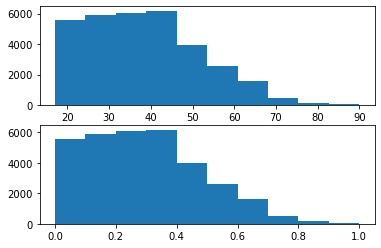

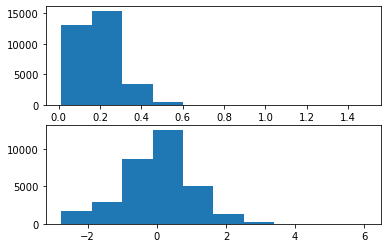

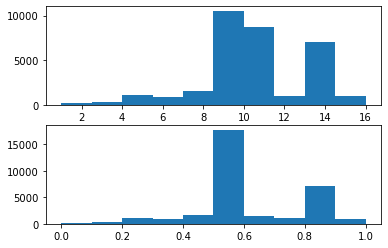

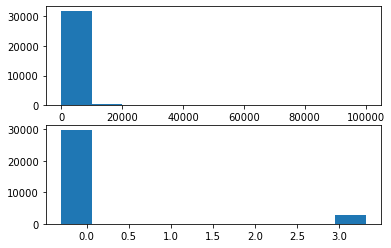

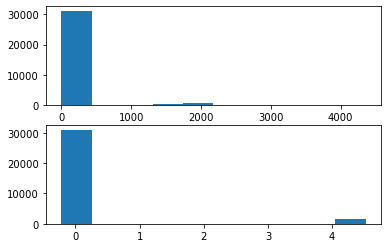

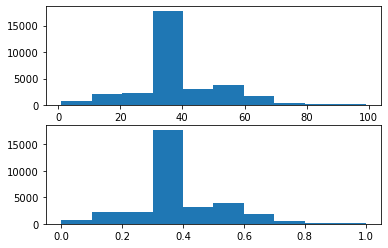

In [82]:
sparse_features = ['feature_2', 'feature_10', 'feature_11']
for feature in data.select_dtypes(include='int64').columns:
    fig, axs = plt.subplots(2)
    axs[0].hist(data[feature])
    if feature in sparse_features:
#         scaler = RobustScaler(unit_variance=True)
        scaler = PowerTransformer()
        data_preprocessed = scaler.fit_transform(data[feature].values.reshape(-1, 1))
#         data_preprocessed = np.log10(data[feature].values.reshape(-1, 1) + 1)
    else:
        scaler = MinMaxScaler()
        data_preprocessed = scaler.fit_transform(data[feature].values.reshape(-1, 1))
    data[feature] = data_preprocessed
    axs[1].hist(data_preprocessed)
    plt.tight_layout
    plt.show()
    plt.close()

In [83]:
get_score_classification(data, target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min finished


0:	learn: 0.5053381	total: 7.77ms	remaining: 552ms
1:	learn: 0.4228037	total: 19.1ms	remaining: 669ms
2:	learn: 0.3796937	total: 33.9ms	remaining: 779ms
3:	learn: 0.3537947	total: 45ms	remaining: 764ms
4:	learn: 0.3389775	total: 52ms	remaining: 697ms
5:	learn: 0.3303522	total: 58.5ms	remaining: 643ms
6:	learn: 0.3237373	total: 64.2ms	remaining: 596ms
7:	learn: 0.3180205	total: 70ms	remaining: 560ms
8:	learn: 0.3132630	total: 75.9ms	remaining: 531ms
9:	learn: 0.3099583	total: 81.7ms	remaining: 506ms
10:	learn: 0.3066444	total: 88.2ms	remaining: 489ms
11:	learn: 0.3049138	total: 94ms	remaining: 470ms
12:	learn: 0.3030509	total: 99.3ms	remaining: 450ms
13:	learn: 0.3017057	total: 105ms	remaining: 434ms
14:	learn: 0.3006198	total: 111ms	remaining: 423ms
15:	learn: 0.2991096	total: 117ms	remaining: 409ms
16:	learn: 0.2980992	total: 123ms	remaining: 398ms
17:	learn: 0.2971238	total: 130ms	remaining: 391ms
18:	learn: 0.2969885	total: 135ms	remaining: 375ms
19:	learn: 0.2961937	total: 141ms	re

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.3s finished


for model xgb results are {'accuracy': [0.8621007371007371], 'f1_': [0.8006260200919937], 'jaccard': [0.7576248313090418], 'recall': [0.8621007371007371]}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.4s finished
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
for model lgbm results are {'accuracy': [0.8657862407862408], 'f1_': [0.8077463699235847], 'jaccard': [0.7633360411589494], 'recall': [0.8657862407862408]}


C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9133192881464222

Generation 2 - Current best internal CV score: 0.9133192881464222

Generation 3 - Current best internal CV score: 0.9133192881464222

Generation 4 - Current best internal CV score: 0.9134738383653891

Generation 5 - Current best internal CV score: 0.9134738383653891

Best pipeline: GradientBoostingClassifier(ZeroCount(input_matrix), learning_rate=1.0, max_depth=2, max_features=0.2, min_samples_leaf=14, min_samples_split=11, n_estimators=100, subsample=0.7000000000000001)
for model TPOT results are {'accuracy': [0.8562653562653563], 'f1_': [0.7920867014915293], 'jaccard': [0.748657357679914], 'recall': [0.8562653562653563]}


## Breast_Cancer

In [6]:
df = original_cls_df[1][0]
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
label = df['diagnosis']
data = df.drop(columns=['id', 'diagnosis'])

data.shape

(569, 30)

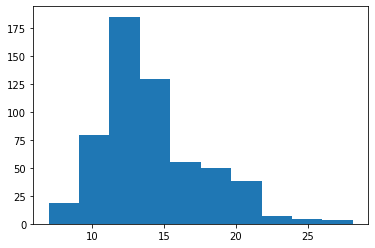

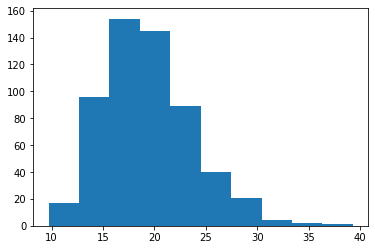

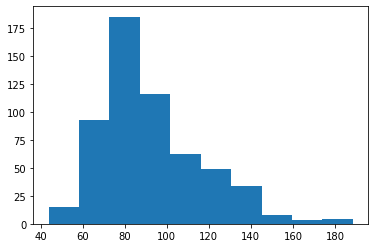

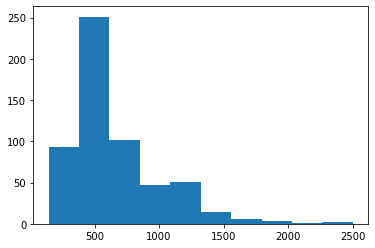

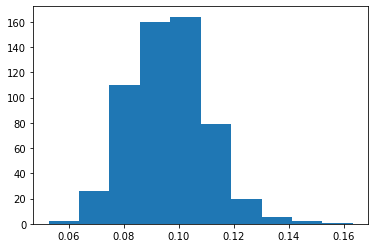

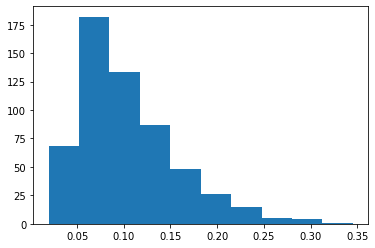

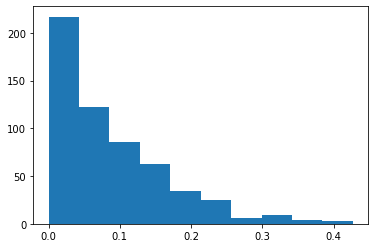

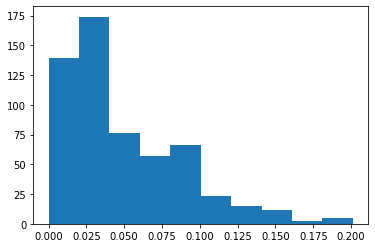

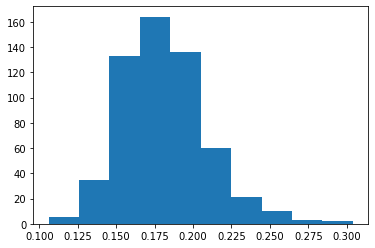

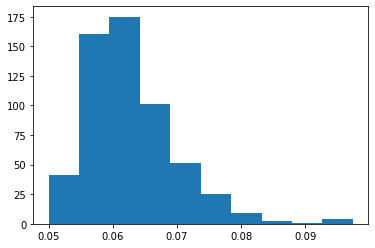

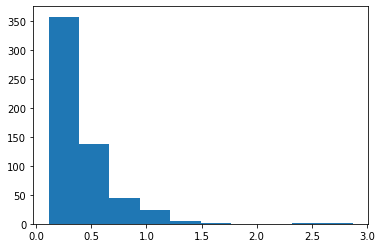

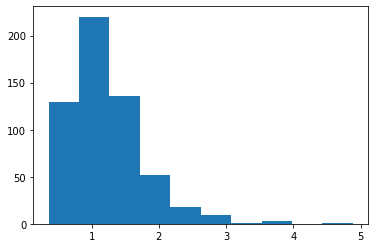

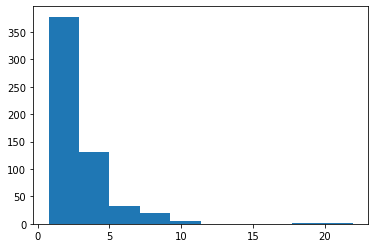

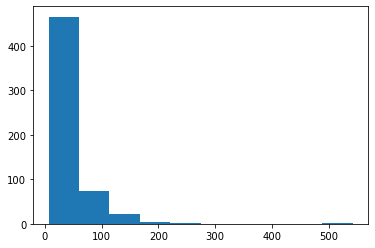

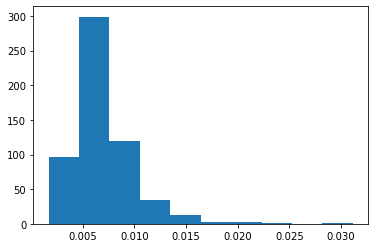

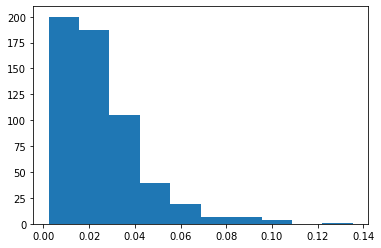

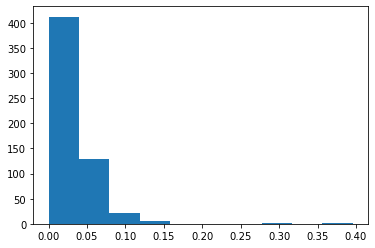

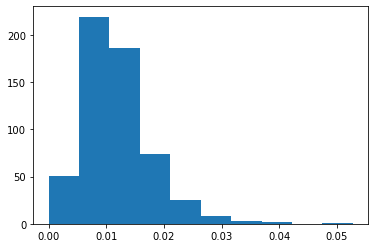

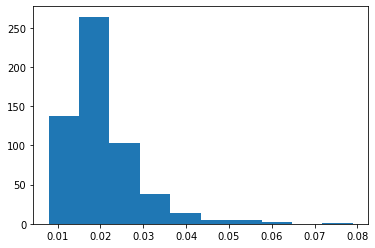

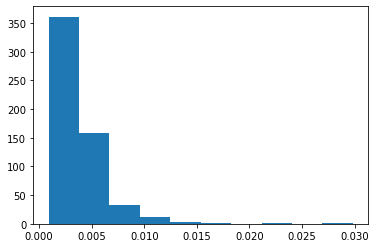

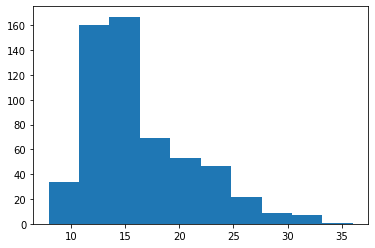

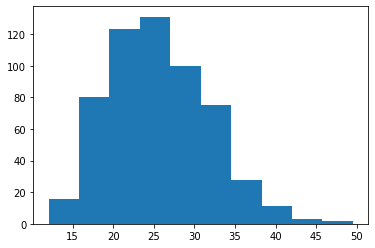

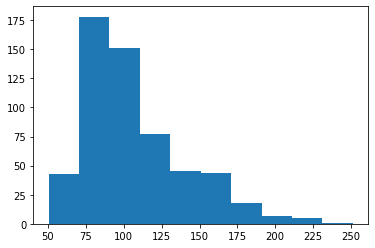

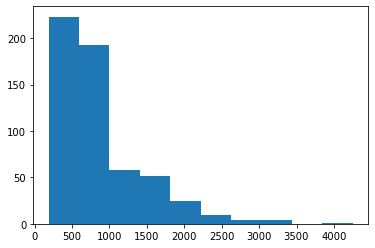

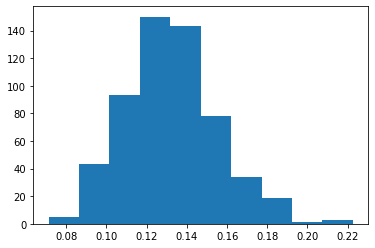

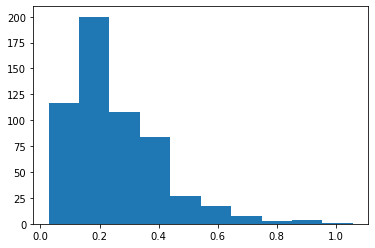

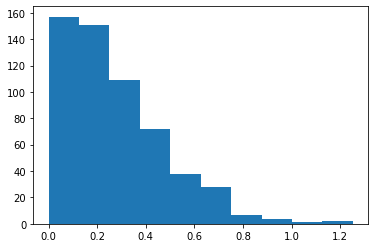

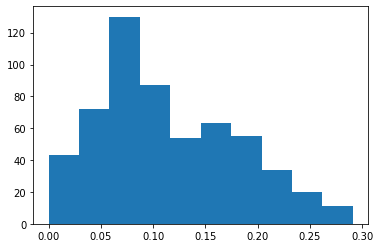

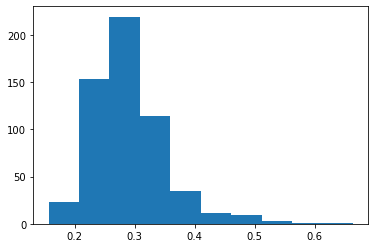

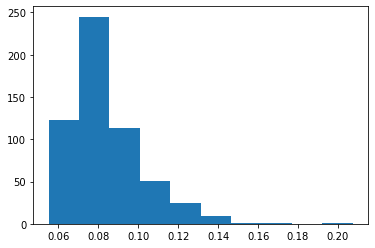

In [8]:
for feature in data.columns:
    plt.hist(data[feature])
    plt.tight_layout
    plt.show()
    plt.close()

In [9]:
label = pd.DataFrame(pd.factorize(label)[0])

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, stratify=label)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
get_score_classification(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 15.9min finished


0:	learn: 0.4528359	total: 68.7ms	remaining: 4.88s
1:	learn: 0.3347892	total: 86.7ms	remaining: 3.03s
2:	learn: 0.2581929	total: 99.9ms	remaining: 2.3s
3:	learn: 0.2023827	total: 113ms	remaining: 1.91s
4:	learn: 0.1643204	total: 126ms	remaining: 1.69s
5:	learn: 0.1374079	total: 136ms	remaining: 1.5s
6:	learn: 0.1195715	total: 147ms	remaining: 1.37s
7:	learn: 0.1071056	total: 159ms	remaining: 1.27s
8:	learn: 0.0960051	total: 171ms	remaining: 1.2s
9:	learn: 0.0931342	total: 180ms	remaining: 1.12s
10:	learn: 0.0856422	total: 192ms	remaining: 1.06s
11:	learn: 0.0779295	total: 203ms	remaining: 1.01s
12:	learn: 0.0732031	total: 213ms	remaining: 965ms
13:	learn: 0.0693269	total: 225ms	remaining: 933ms
14:	learn: 0.0662899	total: 237ms	remaining: 900ms
15:	learn: 0.0594244	total: 251ms	remaining: 880ms
16:	learn: 0.0561996	total: 264ms	remaining: 853ms
17:	learn: 0.0534402	total: 276ms	remaining: 828ms
18:	learn: 0.0482609	total: 293ms	remaining: 818ms
19:	learn: 0.0471900	total: 309ms	remaini

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[13:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for model xgb results are {'accuracy': [0.9824561403508771], 'f1_': [0.9811507936507937], 'jaccard': [0.9655172413793104], 'recall': [0.9824561403508771]}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s finished
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
for model lgbm results are {'accuracy': [0.9824561403508771], 'f1_': [0.9811507936507937], 'jaccard': [0.9655172413793104], 'recall': [0.9824561403508771]}


C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9953560371517028

Generation 2 - Current best internal CV score: 0.9953560371517028

Generation 3 - Current best internal CV score: 0.9953560371517028

Generation 4 - Current best internal CV score: 0.9953560371517028

Generation 5 - Current best internal CV score: 0.9955624355005159

Best pipeline: SGDClassifier(input_matrix, alpha=0.001, eta0=0.1, fit_intercept=True, l1_ratio=0.5, learning_rate=constant, loss=log, penalty=elasticnet, power_t=100.0)
for model TPOT results are {'accuracy': [0.9824561403508771], 'f1_': [0.9811507936507937], 'jaccard': [0.9655172413793104], 'recall': [0.9824561403508771]}


## Car.data

In [35]:
df = pd.read_table(path_classification+'car.data', delimiter=',')
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [36]:
df.shape

(1727, 7)

In [25]:
df.isnull().sum()

vhigh      0
vhigh.1    0
2          0
2.1        0
small      0
low        0
unacc      0
dtype: int64

In [26]:
df.dtypes

vhigh      object
vhigh.1    object
2          object
2.1        object
small      object
low        object
unacc      object
dtype: object

In [30]:
data = my_categorize(df.drop(columns=['unacc']))
data.head()

,vhigh_high,vhigh_low,vhigh_med,vhigh_vhigh,vhigh.1_high,vhigh.1_low,vhigh.1_med,vhigh.1_vhigh,2_2,2_3,...,2_5more,2.1_2,2.1_4,2.1_more,small_big,small_med,small_small,low_high,low_low,low_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [31]:
data.columns

Index(['vhigh_high', 'vhigh_low', 'vhigh_med', 'vhigh_vhigh', 'vhigh.1_high',
       'vhigh.1_low', 'vhigh.1_med', 'vhigh.1_vhigh', '2_2', '2_3', '2_4',
       '2_5more', '2.1_2', '2.1_4', '2.1_more', 'small_big', 'small_med',
       'small_small', 'low_high', 'low_low', 'low_med'],
      dtype='object')

In [33]:
label = df['unacc']
label = pd.DataFrame(pd.factorize(label)[0])

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, stratify=label)

In [34]:
get_score_classification(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.7s finished


0:	learn: 0.8197626	total: 3.79ms	remaining: 269ms
1:	learn: 0.6197054	total: 7.39ms	remaining: 259ms
2:	learn: 0.5339167	total: 8.87ms	remaining: 204ms
3:	learn: 0.3992646	total: 12.6ms	remaining: 214ms
4:	learn: 0.3477072	total: 15.6ms	remaining: 209ms
5:	learn: 0.3162591	total: 18.6ms	remaining: 205ms
6:	learn: 0.2859285	total: 21.5ms	remaining: 200ms
7:	learn: 0.2441369	total: 24.6ms	remaining: 196ms
8:	learn: 0.2120510	total: 27.6ms	remaining: 193ms
9:	learn: 0.1902971	total: 30.7ms	remaining: 190ms
10:	learn: 0.1784753	total: 33.7ms	remaining: 187ms
11:	learn: 0.1675416	total: 36.7ms	remaining: 184ms
12:	learn: 0.1566546	total: 39.7ms	remaining: 180ms
13:	learn: 0.1499986	total: 42.7ms	remaining: 177ms
14:	learn: 0.1423344	total: 45.7ms	remaining: 174ms
15:	learn: 0.1325145	total: 48.8ms	remaining: 171ms
16:	learn: 0.1210195	total: 51.8ms	remaining: 168ms
17:	learn: 0.1104984	total: 54.8ms	remaining: 164ms
18:	learn: 0.1041158	total: 57.8ms	remaining: 161ms
19:	learn: 0.0972774	t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.0s finished


for model xgb results are {'accuracy': [0.9942196531791907], 'f1_': [0.9788961038961039], 'jaccard': [0.9885057471264368], 'recall': [0.9942196531791907]}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.0s finished
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
for model lgbm results are {'accuracy': [1.0], 'f1_': [1.0], 'jaccard': [1.0], 'recall': [1.0]}


C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\tpot\tpot.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pretest_y[0:unique_target_idx.shape[0]] = \
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\RONENAH\Anaconda3\envs\formation_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed whe

ValueError: got predict_proba of shape (10, 4), but need classifier with two classes for roc_auc_score scoring